In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [3]:
train_path = "C:\\Users\\Ajit Govind Kulkarni\\train"
valid_path = "C:\\Users\\Ajit Govind Kulkarni\\val"
test_path = "C:\\Users\\Ajit Govind Kulkarni\\test"

# Data Preprocessing

In [7]:
traindatagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
train_batches=traindatagen.flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)

Found 3319 images belonging to 12 classes.


In [8]:
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_batches = valid_datagen.flow_from_directory(directory=valid_path,shuffle = False, target_size=(224,224), batch_size=10)

Found 1431 images belonging to 12 classes.


In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_batches = test_datagen.flow_from_directory(directory=test_path,shuffle = False, target_size=(224,224), batch_size=10)

Found 794 images belonging to 1 classes.


In [10]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [11]:
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
x = mobile.layers[-6].output
flatten=Flatten()(x)
bn=BatchNormalization()(flatten)
do=Dropout(0.5)(bn)
output = Dense(units=12, activation='softmax')(do)
model = Model(inputs=mobile.input, outputs=output)

In [12]:
for layer in model.layers[:-20]:
    layer.trainable = False

In [ ]:
# Observations:

# Flatten layer is added followed by a batch normalization and one dense layers
# Last layer is softmax and contain 6 units, because we have 12 classes of images
# All layers are frozen except last twenty

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
filepath="weights_mobileNet_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',save_weights_only=False,verbose=0,  save_best_only=True, mode='max')

In [15]:
history = model.fit_generator(train_batches,validation_data=valid_batches, epochs=50)

Epoch 1/50
332/332 [==============================] - 1054s 3s/step - loss: 2.0549 - accuracy: 0.4209 - val_loss: 0.9085 - val_accuracy: 0.7268
Epoch 2/50
332/332 [==============================] - 995s 3s/step - loss: 1.2365 - accuracy: 0.6400 - val_loss: 0.6996 - val_accuracy: 0.7841
Epoch 3/50
332/332 [==============================] - 697s 2s/step - loss: 1.0207 - accuracy: 0.6975 - val_loss: 0.6226 - val_accuracy: 0.8176
Epoch 4/50
332/332 [==============================] - 528s 2s/step - loss: 0.9113 - accuracy: 0.7312 - val_loss: 0.5985 - val_accuracy: 0.8288
Epoch 5/50
332/332 [==============================] - 527s 2s/step - loss: 0.8521 - accuracy: 0.7475 - val_loss: 0.5922 - val_accuracy: 0.8407
Epoch 6/50
332/332 [==============================] - 473s 1s/step - loss: 0.7960 - accuracy: 0.7680 - val_loss: 0.5681 - val_accuracy: 0.8435
Epoch 7/50
332/332 [==============================] - 488s 1s/step - loss: 0.7361 - accuracy: 0.7870 - val_loss: 0.5748 - val_accuracy: 0.847

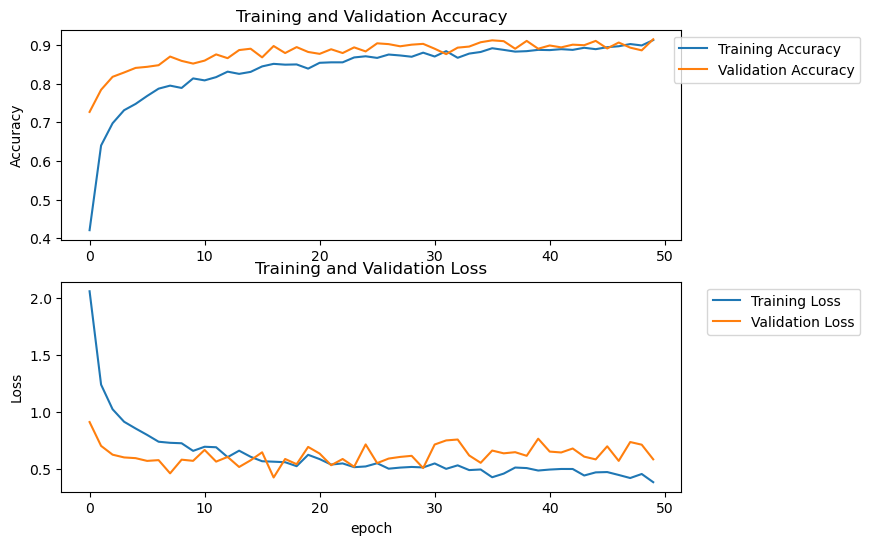

In [16]:
import matplotlib.pyplot as plt

acc      = model.history.history['accuracy']
val_acc  = model.history.history['val_accuracy']
loss     = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(bbox_to_anchor=(1.3, 1),loc='upper right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(bbox_to_anchor=(1.3, 1),loc='upper right')
plt.ylabel('Loss')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
model.save('R4_MobileNet.h5')
R4MobileNet = tf.keras.models.load_model('R4_MobileNet.h5')
predictionsV4 = R4MobileNet.predict(x=valid_batches, steps=len(valid_batches), verbose=0)
scores = R4MobileNet.evaluate(valid_batches, verbose=0)
print("%s: %.2f%%" % (R4MobileNet.metrics_names[1], scores[1]*100))

accuracy: 91.47%


                           precision    recall  f1-score   support

              Black-grass       0.65      0.53      0.58        79
                 Charlock       1.00      0.97      0.98       117
                 Cleavers       0.93      0.97      0.95        87
         Common Chickweed       0.98      0.97      0.98       184
             Common wheat       0.89      0.85      0.87        67
                  Fat Hen       0.96      0.92      0.94       143
         Loose Silky-bent       0.81      0.91      0.86       197
                    Maize       0.96      0.96      0.96        67
        Scentless Mayweed       0.91      0.89      0.90       155
          Shepherds Purse       0.81      0.90      0.85        70
Small-flowered Cranesbill       0.99      0.99      0.99       149
               Sugar beet       0.97      0.95      0.96       116

                 accuracy                           0.91      1431
                macro avg       0.91      0.90      0.90    

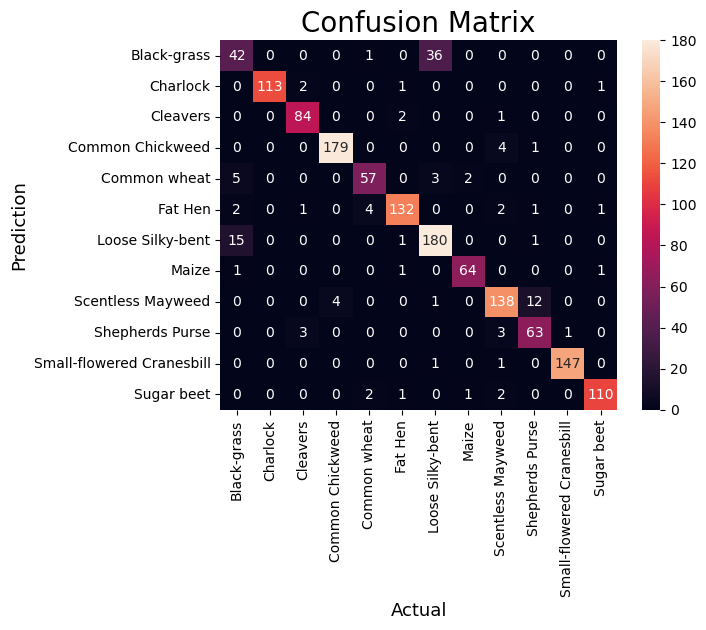

In [21]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
import seaborn as sns

target_names = ['Black-grass','Charlock','Cleavers','Common Chickweed','Common wheat','Fat Hen', 'Loose Silky-bent',
                'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

y_true=valid_batches.classes 
y_pred=predictionsV4.argmax(axis=1)

# Classification Report
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
#compute the confusion matrix.
cm = confusion_matrix(y_true,y_pred)
 
#Plot the confusion matrix.
fig=sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Black-grass','Charlock','Cleavers','Common Chickweed','Common wheat','Fat Hen', 'Loose Silky-bent',
                'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet'],
            yticklabels=['Black-grass','Charlock','Cleavers','Common Chickweed','Common wheat','Fat Hen', 'Loose Silky-bent',
                'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=20)
plt.show()

In [22]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [23]:
test_batches.filenames[:5]

['test\\0021e90e4.png',
 'test\\003d61042.png',
 'test\\007b3da8b.png',
 'test\\0086a6340.png',
 'test\\00c47e980.png']

In [24]:
preds_cls_idx = predictions.argmax(axis=-1)

In [25]:
# https://stackoverflow.com/questions/57516673/how-to-perform-prediction-using-predict-generator-on-unlabeled-test-data-in-kera
import numpy as np
idx_to_cls = {v: k for k, v in train_batches.class_indices.items()}
preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx)
filenames_to_cls = list(zip(test_batches.filenames, preds_cls))

In [26]:
filenames_to_cls[:5]

[('test\\0021e90e4.png', 'Small-flowered Cranesbill'),
 ('test\\003d61042.png', 'Fat Hen'),
 ('test\\007b3da8b.png', 'Sugar beet'),
 ('test\\0086a6340.png', 'Common Chickweed'),
 ('test\\00c47e980.png', 'Sugar beet')]

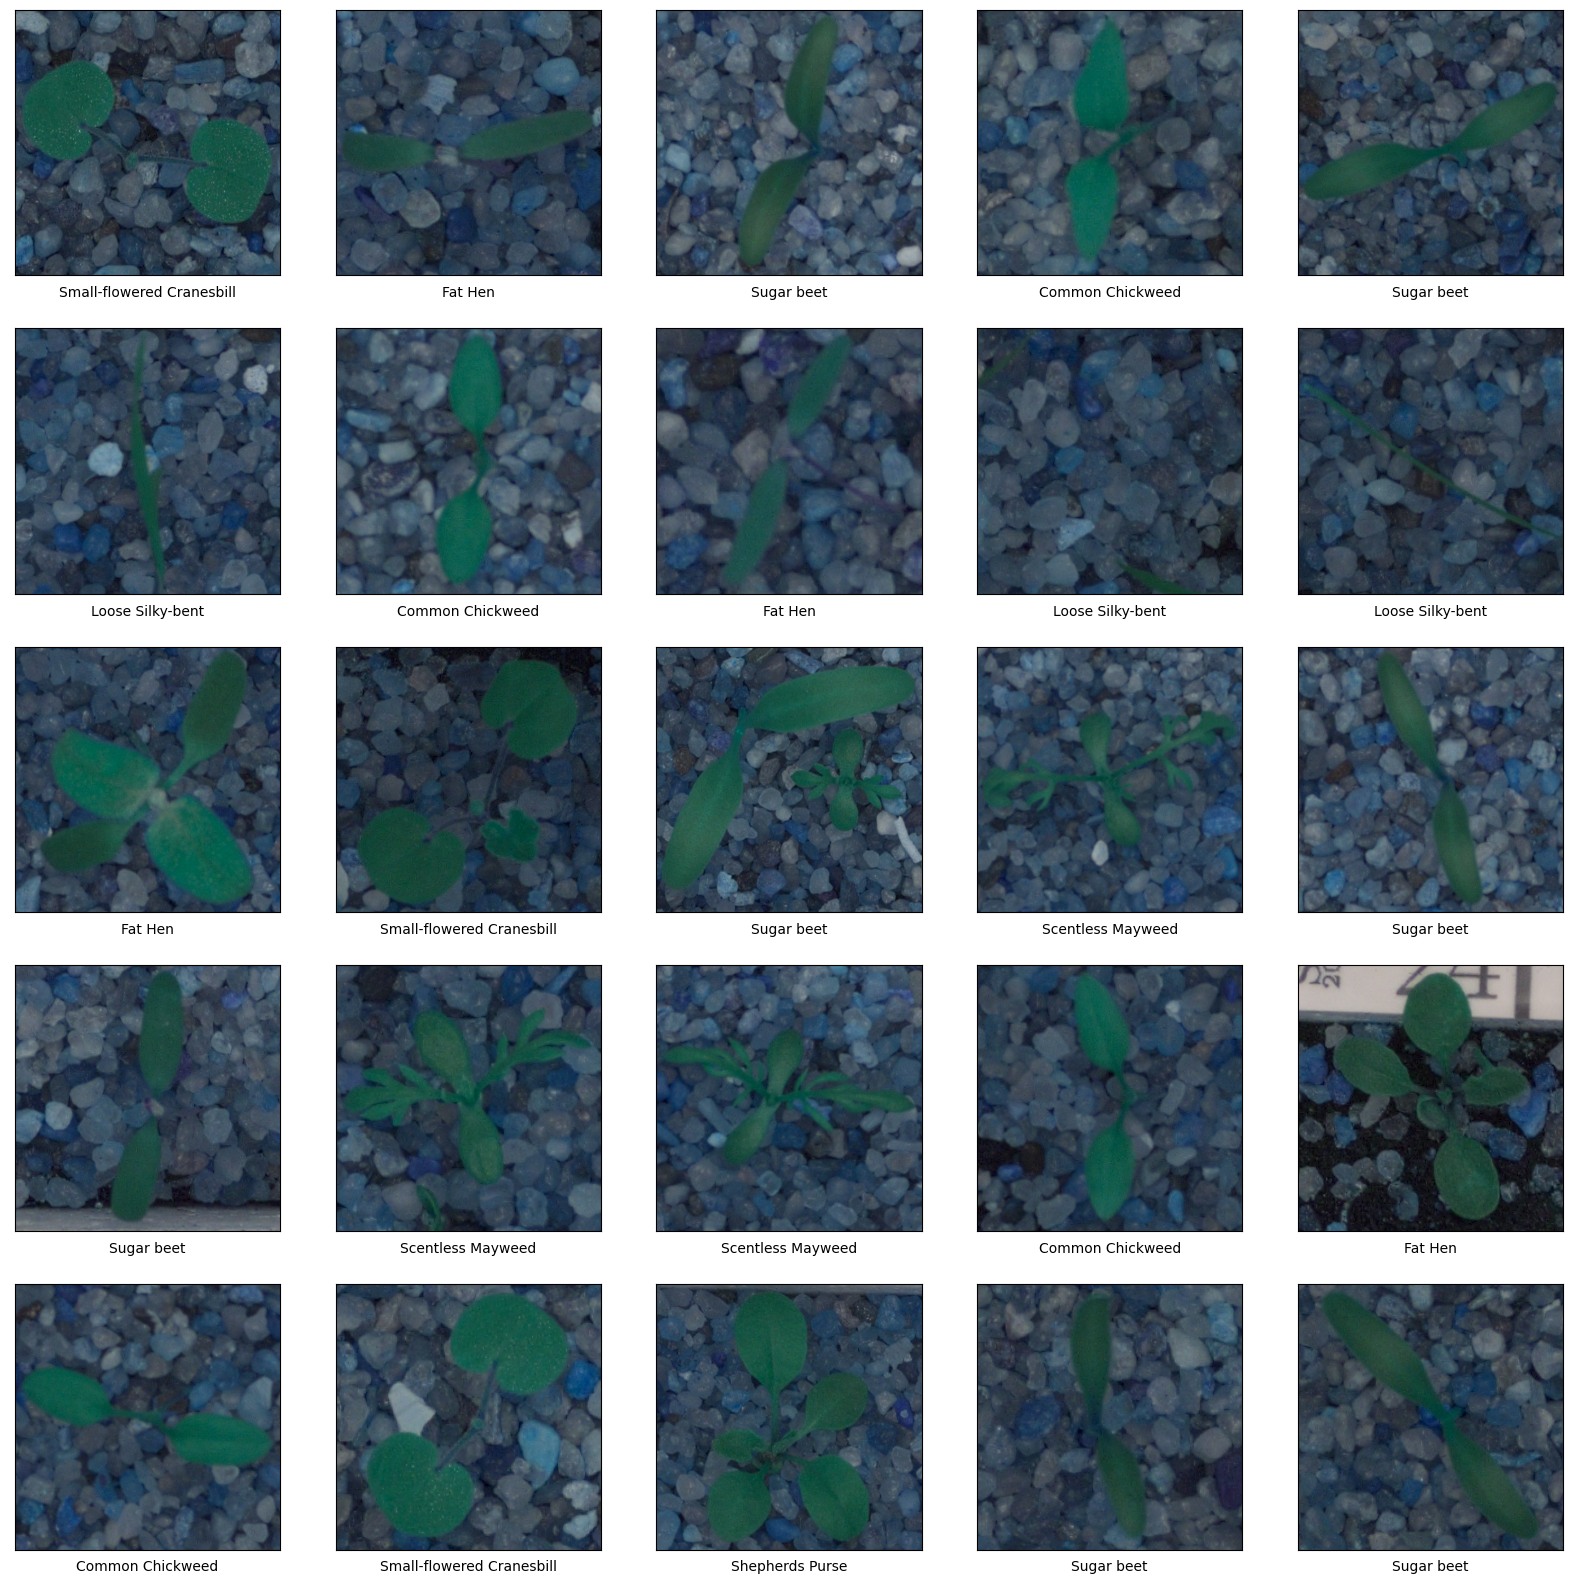

In [27]:
import cv2 as cv
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = cv.imread(r'test\\'+ filenames_to_cls[i][0])
    plt.imshow(img)
    plt.xlabel(filenames_to_cls[i][1])
plt.show()